In [2]:
from __future__ import division
%matplotlib nbagg
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from src.python_latexify import latexify, format_axes
import matplotlib
matplotlib.rcParams.update(latexify())


#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 14}
#matplotlib.rc('font', **font)
import matplotlib.pyplot as plt

# CURRENTLY BASED ON 317 sIPs

In [3]:
# UPDATED SERVERS IMC
df_sIP_subcat = pd.read_csv("utils/Servers_IMC-original.txt")
df_sIP_subcat['subcat'] = df_sIP_subcat['subcat'].apply(lambda x: x.replace('kids_and_teens', 'teens'))


subcat_duplicated = defaultdict(list)
for ix, row in df_sIP_subcat.iterrows():
    if len(row[2].split("|"))>1:
        shared = 1
    else:
        shared = 0
    for subcat in row[2].split("|"):
        if subcat == 'kids_and_teens':
            subcat = 'teens'
        subcat_duplicated['sIP'].append(row[0])
        subcat_duplicated['domain'].append(row[1])
        subcat_duplicated['subcat'].append(subcat)
        subcat_duplicated['shared'].append(shared)
df_sIP_subcat_disjoint = pd.DataFrame(subcat_duplicated)

In [4]:
print len(df_sIP_subcat), len(df_sIP_subcat_disjoint)
valid_sIPs = df_sIP_subcat['sIP'].unique()
print "VALID sIPs Unique = ", len(valid_sIPs), len(df_sIP_subcat_disjoint['sIP'].unique())

580 875
VALID sIPs Unique =  580 580


In [5]:
DATA = "data/"
PLOTS = "results/final_figures-20150429/plots-317sIPs/"
TABLES = "results/final_figures-20150429/tables-317sIPs/"
#PLOTS = "results/final_figures-20150429/plots-298sIPs/"
#TABLES = "results/final_figures-20150429/tables-298sIPs/"
if not os.path.exists(PLOTS):
    os.makedirs(PLOTS)
if not os.path.exists(TABLES):
    os.makedirs(TABLES)

# DATA: Apr 23 + 27: only 317 sIPs filtered

In [6]:
df_all1 = pd.read_pickle(DATA + "case_detected_all_20150423.pkl")
df_all2 = pd.read_pickle(DATA + "case_detected_all_20150427.pkl")
df_all = pd.concat([df_all1,df_all2])
print len(df_all1), len(df_all2), len(df_all)

250593 146328 396921


# CONFUSING CASES SE/US

In [7]:
from src.censorship_ratios import *

In [8]:
df_rej = pd.read_pickle("results/old_results/sIP_sanitize_20150426/df_sanitize_sIP.pkl")
confusing_cases = df_rej[ (df_rej['IP.anycast'] != -1) & (df_rej['CENSOR.US'] < 1) & 
                         (df_rej['CENSOR.SE'] < 1) & (df_rej['CENSOR.US'] > 0) & 
                         (df_rej['CENSOR.SE'] > 0)]
confusing_cases.to_html(TABLES + "confusing_cases_case123_all.html")

In [9]:
CONFUSING_IPs = ['162.159.244.215', '104.20.5.196', '198.41.188.234', '190.93.245.117']
CONFUSING_DOMs = list(confusing_cases.iloc[3:7]['domain'])
print CONFUSING_DOMs

['economist.com', 'uproxy.org', 'oneswarm.org', 'expedia.com']


In [10]:
df_mock = pd.read_pickle(DATA + "case_detected_all_20150412.pkl")
df_full = pd.concat([df_mock, df_all])
del df_mock, df_all

## Interesting Ratios

In [24]:
almost_all_info = df_full[df_full['sIP'].isin(CONFUSING_IPs) |
        df_full['domain'].isin(CONFUSING_DOMs)].groupby(['sIP', 'domain', 'country', 'case'])['port'].count().unstack()
all_info = almost_all_info

In [18]:
all_info = df_full.groupby(['sIP', 'domain', 'country', 'case'])['port'].count().unstack()

In [25]:
case23 = all_info[(all_info[2] > 0) & (all_info[3] > 0) & (all_info[1] == 0)].stack()
case13 = all_info[(all_info[1] > 0) & (all_info[3] > 0) & (all_info[2] == 0)].stack()
case12 = all_info[(all_info[1] > 0) & (all_info[2] > 0) & (all_info[3] == 0)].stack()
case123 = all_info[(all_info[1] > 0) & (all_info[3] > 0) & (all_info[2] > 0)].stack()
print len(case23), len(case13), len(case12), len(case123)

0 0 0 71


In [26]:
df_wierd = case123.unstack(3)
df_wierd['tot']= df_wierd[[1,2,3]].sum(1)
df_wierd['err']= df_wierd[[0,4]].sum(1)
df_wierd['case2']=df_wierd[1]/df_wierd['tot']
df_wierd['case1']=df_wierd[2]/df_wierd['tot']
df_wierd['case3']=df_wierd[3]/df_wierd['tot']
df_wierd['case13']=(df_wierd[1]+df_wierd[2])/df_wierd['tot']
df_wierd2 = df_wierd[['tot', 'err', 'case2','case1', 'case3', 'case13']].fillna(0)
df_wierd2.to_html(TABLES + "confusing_anycast_CDNs_examples.html")
#df_wierd2

df_short = pd.read_pickle("results/old_results/sIP_sanitize_20150426/df_sanitize_sIP_short.pkl")
df_useful = df_short[ df_short['sIP'].isin(df_wierd2.reset_index()['sIP'].unique()) ][[
        'sIP','domain','subcat', 'IP.anycast','DOMAIN.DNS_contains','DOMAIN.sIP_http_reach','CENSOR.US','CENSOR.SE']]
df_full_info = df_wierd2.reset_index().merge(df_useful, on=['sIP', 'domain'])
#df_full_info.to_html(TABLES + "confusing_anycast_CDNs_full_table.html")

In [27]:
df = df_full[df_full['sIP']==CONFUSING_IPs[0]]
temp = get_censorship_by_country_sIP(df).T.reset_index()
temp[temp[CONFUSING_IPs[0]]<1]

sIP,country,162.159.244.215
3,AM,0.666667
5,AR,0.750000
86,MN,0.000000
146,global,0.997070


In [29]:
df = df_full[df_full['sIP']==CONFUSING_IPs[2]]
temp = get_censorship_by_country_sIP(df).T.reset_index()
temp[temp[CONFUSING_IPs[2]]<1]

sIP,country,198.41.188.234
44,GB,0.923077
58,IL,0.750000
103,PE,0.666667
147,global,0.996622


In [30]:
df = df_full[df_full['sIP']==CONFUSING_IPs[3]]
temp = get_censorship_by_country_sIP(df).T.reset_index()
temp[temp[CONFUSING_IPs[3]]<1]

sIP,country,190.93.245.117
23,CG,0.666667
146,global,0.998759


In [31]:
diff_list = defaultdict(list)

country = 'AR'
case = 2
sIP = CONFUSING_IPs[0]
diff_list1 = df_full[(df_full['country']==country) & (df_full['sIP']==sIP)
                     & (df_full['case']==case)]['diff_list'].values[0]

diff_list['country'].append(country)
diff_list['case'].append(case)
diff_list['sIP'].append(sIP)
diff_list['diff_list'].append(diff_list1)

case = 3
diff_list1 = df_full[(df_full['country']==country) & (df_full['sIP']==sIP)
                     & (df_full['case']==case)]['diff_list'].values[0]
diff_list['country'].append(country)
diff_list['case'].append(case)
diff_list['sIP'].append(sIP)
diff_list['diff_list'].append(diff_list1)

country = 'GB'
case = 2
sIP = CONFUSING_IPs[2]
diff_list1 = df_full[(df_full['country']==country) & (df_full['sIP']==sIP)
                     & (df_full['case']==case)]['diff_list'].values[0]
diff_list['country'].append(country)
diff_list['case'].append(case)
diff_list['sIP'].append(sIP)
diff_list['diff_list'].append(diff_list1)


case=3
diff_list1 = df_full[(df_full['country']==country) & (df_full['sIP']==sIP)
                     & (df_full['case']==case)]['diff_list'].values[0]
diff_list['country'].append(country)
diff_list['case'].append(case)
diff_list['sIP'].append(sIP)
diff_list['diff_list'].append(diff_list1)

df_diff_example = pd.DataFrame(diff_list)

In [32]:
df_diff_example

,case,country,diff_list,sIP
0,2,AR,"[4, 0, 0, 0, 1, 5, None, None, 0, 0, 0, 0, 0, ...",162.159.244.215
1,3,AR,"[None, None, None, None, None, 4, 0, 0, 0, 0, ...",162.159.244.215
2,2,GB,"[None, 1, 2, 0, 0, 1, 1, None, None, None, Non...",198.41.188.234
3,3,GB,"[2, 2, 17, 5, 6, 2, 1, 2, 6, 12, 3, 2, 2, 4, 9...",198.41.188.234


<IPython.core.display.Javascript object>


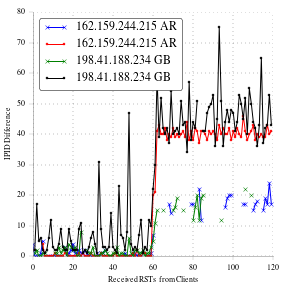

2 AR 162.159.244.215 sheknows.com
3 AR 162.159.244.215 sheknows.com
2 GB 198.41.188.234 newgrounds.com
3 GB 198.41.188.234 newgrounds.com


In [47]:
fig1, ax1 = plt.subplots(1,1, figsize=(4,4))
m = ['x', '.', 'x', '.']
c = 'brgk'
#ls = ['-.', '--', '-']
i = 0

for ix, row in df_diff_example.iterrows():
    case=row['case']
    country=row['country']
    diff_l = row['diff_list']
    sIP = row['sIP']
    dom = df_sIP_subcat[df_sIP_subcat['sIP']==sIP]['domain'].values[0]
    print case, country, sIP, dom
    
    ax1.plot(range(len(diff_l)), diff_l, marker=m[i], markersize=4, lw=1, label=sIP+" "+country, color=c[i])
    i += 1

ax1.grid(1)
ax1.set_xlabel("Received RSTs from Clients")
ax1.set_ylabel("IPID Difference")
ax1.set_ylim([0, 80])
ax1.legend(loc=2, fontsize=12)
fig1.tight_layout()
format_axes(ax1)
fig1.savefig(PLOTS + "strangeCases")
fig1.savefig(PLOTS + "strangeCases.pdf")

In [41]:
df = df_full[df_full['sIP']==CONFUSING_IPs[2]]
get_censorship_by_country_sIP(df)

country,AE,AF,AL,AM,AO,AR,AT,AU,AZ,BA,...,UG,US,UY,UZ,VE,VN,ZA,ZM,ZW,global
sIP,,,,,,,,,,,,,,,,,,,,,
198.41.188.234,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.996622


In [42]:
df = df_full[df_full['sIP']==CONFUSING_IPs[3]]
get_censorship_by_country_sIP(df)

country,AE,AF,AL,AM,AO,AR,AT,AU,AZ,BA,...,UG,US,UY,UZ,VE,VN,ZA,ZM,ZW,global
sIP,,,,,,,,,,,,,,,,,,,,,
190.93.245.117,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0.998759


In [43]:
df = df_full[df_full['domain']==CONFUSING_DOMs[0]]
get_censorship_by_country_sIP(df)

country,AE,AF,AL,AM,AO,AR,AT,AU,AZ,BA,...,UG,US,UY,UZ,VE,VN,ZA,ZM,ZW,global
sIP,,,,,,,,,,,,,,,,,,,,,
216.239.34.21,0.75,1,0.285714,0.571429,1,0.888889,0.5,1,0.333333,1,...,1,0.587629,0.666667,1,0.8,0.8,0.111111,1,1,0.827487


In [44]:
df = df_full[df_full['domain']==CONFUSING_DOMs[1]]
get_censorship_by_country_sIP(df)

country,AE,AF,AL,AM,AO,AR,AT,AU,AZ,BA,...,UG,US,UY,UZ,VE,VN,ZA,ZM,ZW,global
sIP,,,,,,,,,,,,,,,,,,,,,
216.239.38.21,1,1,0.5,0.571429,1,0.909091,0.7,0.8,0.714286,1,...,1,0.550562,0.857143,1,0.857143,1,0.454545,1,0.875,0.819268


In [45]:
df = df_full[df_full['domain']==CONFUSING_DOMs[2]]
get_censorship_by_country_sIP(df)

country,AE,AF,AL,AM,AO,AR,AT,AU,AZ,BA,...,UG,US,UY,UZ,VE,VN,ZA,ZM,ZW,global
sIP,,,,,,,,,,,,,,,,,,,,,
216.239.32.21,0.5,1,0.285714,0.571429,1,1,0.777778,0.857143,0.714286,1,...,1,0.543478,0.833333,1,0.666667,0.833333,0.666667,1,0.666667,0.83455


In [46]:
df = df_full[df_full['domain']==CONFUSING_DOMs[3]]
get_censorship_by_country_sIP(df)

country,AE,AF,AL,AM,AO,AR,AT,AU,AZ,BA,...,UG,US,UY,UZ,VE,VN,ZA,ZM,ZW,global
sIP,,,,,,,,,,,,,,,,,,,,,
204.74.99.101,0.142857,1,0.5,0.8,1,0.875,0.714286,0.333333,0.666667,1,...,1,0.425287,NaN,NaN,1,0,0.428571,0,1,0.649309


### Use df_disjoint for conclusions on subcats, and df_sanitized for conclusions on sIPs

In [14]:
cens = get_censorship_by_country_sIP(df_all)

In [25]:
cens[['US', 'SE']].join(df_sIP_subcat.set_index('sIP')).sort(['US', 'SE'], ascending=[False, True])

,US,SE,domain,subcat
sIP,,,,
184.25.56.179,1,0.000000,nfl.com,sports
74.125.28.100,1,0.000000,plus.google.com,world|computers
74.117.179.22,1,0.166667,nudevista.com,adult
64.13.149.10,1,0.333333,topix.com,news
199.83.132.16,1,0.500000,purevpn.com,vpn
204.79.197.200,1,0.750000,bing.com,world|computers|reference
104.16.5.13,1,1.000000,change.org,society
104.16.7.118,1,1.000000,petmd.com,health
104.20.12.28,1,1.000000,studentdoctor.net,health


In [6]:
COLS_NEEDED = ['sIP', 'domain', 'subcat', 'country', 'case', 'port']

df_sanitized = df_all[df_all['sIP'].isin(valid_sIPs)].reset_index()[COLS_NEEDED]
df_disjoint = df_sanitized[['sIP', 'country', 'case', 'port']].merge(
    df_sIP_subcat_disjoint[['sIP', 'domain', 'subcat']], on=['sIP']).reset_index()

In [7]:
print "Number of measurements: sanitized=%d; (repeated) disjoint=%d"%((len(df_sanitized), len(df_disjoint)))

Number of measurements: sanitized=249430; (repeated) disjoint=386074


# Helper functions: censorship and technology

In [ ]:
## GET CENSORSHIP INFO
def get_ratios(dfin, GROUP=0):
    ''' assume df_count is indexed'''
    if GROUP:
        df_count = dfin.groupby(['sIP', 'domain', 'subcat',
        'country', 'case'])['port'].count().unstack().fillna(0)
    else:
        df_count = dfin.copy()
    df_count['tot'] = df_count.sum(axis=1)
    
    df_count['err'] = 0
    if (0 in df_count.columns):
        df_count['err']+= df_count[0]
    if (4 in df_count.columns):
        df_count['err']+= df_count[4]

    df_count['tot'] = df_count['tot'] - df_count['err']
    
    if 1 in df_count.columns:
        df_count['case1'] = df_count[1]/df_count['tot']
    if 2 in df_count.columns:
        df_count['case2'] = df_count[2]/df_count['tot']
    if 3 in df_count.columns:
        df_count['case3'] = df_count[3]/df_count['tot']
    return df_count

def get_censorship_by_country_sIP_subcat(df_val, dimension='censorship'):
    """
    groupby sIP subcat + country. Must use disjoint to duplicate measurements
    conclusions drawn by sIP not by subcat
    """
    censorship = df_val.groupby(['sIP', 'domain', 'subcat',
                                 'country', 'case'])['port'].count().unstack().fillna(0)
    censorship = get_ratios(censorship)
    global_censorship = df_val.groupby(['sIP', 'domain',
                                        'subcat', 'case'])['port'].count().unstack().fillna(0)
    global_censorship = get_ratios(global_censorship)
    if dimension == 'censorship':
        censor_country = (1 - censorship['case2']).unstack()
        censor_global = (1 - global_censorship['case2'])
    else:
        # dimension can be err, tot, case1, case2, case3, 1, 2, 3, 4, 0 apart from censorship
        censor_country = censorship[dimension].unstack()
        censor_global = global_censorship[dimension]
        
    censor_country['global'] = censor_global
    #censor_country= censor_country.reset_index()
    return censor_country

def get_censorship_by_country_sIP(df_val, dimension='censorship'):
    """
    only groupby sIP + country, no need to use disjoint repeated measurements
    conclusions drawn by sIP not by subcat
    """
    censorship = df_val.groupby(['sIP', 'country', 'case'])['port'].count().unstack().fillna(0)
    censorship = get_ratios(censorship)
    global_censorship = df_val.groupby(['sIP','case'])['port'].count().unstack().fillna(0)
    global_censorship = get_ratios(global_censorship)
    if dimension == 'censorship':
        censor_country = (1 - censorship['case2']).unstack()
        censor_global = (1 - global_censorship['case2'])
    else:
        # dimension can be err, tot, case1, case2, case3, 1, 2, 3, 4, 0 apart from censorship
        censor_country = censorship[dimension].unstack()
        censor_global = global_censorship[dimension]
        
    censor_country['global'] = censor_global
    #censor_country= censor_country.reset_index()
    return censor_country

def get_censorship_technology_combined(df_val, sliced_sIP_list):
    """ df_val can be filtered to some sIPs only """
    df_sliced = df_val[df_val['sIP'].isin(sliced_sIP_list)]
    
    data_sliced_sIP = defaultdict(int)
    data_sliced_sIP['1'] = get_censorship_by_country_sIP(df_sliced, 1).sum()
    data_sliced_sIP['3'] = get_censorship_by_country_sIP(df_sliced, 3).sum()
    data_sliced_sIP['2'] = get_censorship_by_country_sIP(df_sliced, 3).sum()
    data_sliced_sIP['tot'] = get_censorship_by_country_sIP(df_sliced, 'tot').sum()
    data_sliced_sIP['err'] = get_censorship_by_country_sIP(df_sliced, 'err').sum()
    
    df_sliced_sIP = pd.DataFrame(data_sliced_sIP)
    df_sliced_sIP['unknown']=data_sliced_sIP['err']/(data_sliced_sIP['tot']+data_sliced_sIP['err'])
    df_sliced_sIP['case1']=data_sliced_sIP['1']/data_sliced_sIP['tot']
    df_sliced_sIP['case3']=data_sliced_sIP['3']/data_sliced_sIP['tot']
    df_sliced_sIP['case13']=df_sliced_sIP['case1']+ df_sliced_sIP['case3']
    df_sliced_sIP['case1/case13']=df_sliced_sIP['case1']/df_sliced_sIP['case13']
    
    return df_sliced_sIP

def get_censorship_technology_sIP(df_val):
    """ df_val can be filtered to some sIPs only """
    # by sIP
    case1_tot = get_censorship_by_country_sIP(df_val, 1)
    case3_tot = get_censorship_by_country_sIP(df_val, 3)
    tot = get_censorship_by_country_sIP(df_val, 'tot')
    unknown = get_censorship_by_country_sIP(df_val, 'err')
                                            
    technology = (case1_tot)/(case1_tot+case3_tot)
    censorship = (case1_tot+case3_tot)/tot
    unknown = unknown/tot
    return censorship, technology, unknown

In [1]:
from censorship_ratios import *

In [25]:
df_censorship, df_technology, df_unknown = get_censorship_technology_sIP(df_sanitized)

In [26]:
get_censorship_by_country_sIP(df_sanitized, 'tot').to_html(TABLES + "total_measurements_country_vs_sIP.html")
get_censorship_by_country_sIP(df_sanitized, 'err').to_html(TABLES + "total_unknowns_country_vs_sIP.html")
get_censorship_by_country_sIP(df_sanitized, 'case1').to_html(TABLES + "ratio_case1_country_vs_sIP.html")
get_censorship_by_country_sIP(df_sanitized, 'case2').to_html(TABLES + "ratio_case2_country_vs_sIP.html")
get_censorship_by_country_sIP(df_sanitized, 'case3').to_html(TABLES + "ratio_case3_country_vs_sIP.html")

## Group categs together and see these ratios

In [27]:
df_sIP_subcat_disjoint['subcat'].unique()

array(['science', 'regional', 'health', 'society', 'games', 'adult',
       'shopping', 'recreation', 'world', 'computers', 'reference', 'arts',
       'business', 'news', 'sports', 'home', 'teens', 'circum', 'vpn'], dtype=object)

In [28]:
# list of sIP by subcat: use disjoint
def select_sIP_in_subcat(subcat='circum_vpn'):
    # select both circum or vpn
    sIP_by_subcat = df_sIP_subcat_disjoint.groupby('subcat')['sIP'].unique()
    #subcat = 'circum|vpn'
    sliced_sIP = []
    for categ in subcat.split('_'):
        sliced_sIP += list(sIP_by_subcat[categ])
    print subcat, sliced_sIP
    return sliced_sIP

In [305]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

def get_color(x):
    if x<0.1:
        return 'g'
    elif x>0.2:
        return 'r'
    else:
        return 'y'
#PLOTS = "results/final_figures-20150429/plots/"
#TABLES = "results/final_figures-20150429/tables/"

In [316]:
categs = iter(df_sIP_subcat_disjoint['subcat'].unique())

<IPython.core.display.Javascript object>


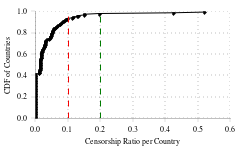

In [306]:
def plot_country_subcat_CDF(df_censor_tech, subcat='vpn'):
    fig1, ax1 = plt.subplots(1,1)
    xdata, ydata = getCDF(df_censor_tech['case13'])
    ax1.plot(xdata, ydata, color='k', marker='.')
    ax1.axvline(0.1, color='r', ls='--')
    ax1.axvline(0.2, color='g', ls='--')
    ax1.grid(1)
    ax1.set_ylabel("CDF of Countries")
    ax1.set_xlabel("Censorship Ratio per Country")
    fig1.tight_layout()
    format_axes(ax1)
    fig1.savefig(PLOTS + "censorship_ratio_CDF_countries_"+subcat)
    fig1.savefig(PLOTS + "censorship_ratio_CDF_countries_"+subcat+"pdf")
    return

In [319]:
def plot_country_technique_for_subcat(subcat='vpn'):
    print subcat
    sliced_sIP = select_sIP_in_subcat(subcat)
    df_censor_tech = get_censorship_technology_combined(df_sanitized, sliced_sIP)
    df_censor_tech.sort(columns='case13', ascending=False, inplace=True)
    
    plot_country_subcat_CDF(df_censor_tech, subcat)
    
    df = df_censor_tech['case1/case13']
    technology_country = pd.cut(df, 10)
    df_cuts = pd.DataFrame(technology_country).join(df_censor_tech['case13']).rename(columns=\
                        {'case1/case13':'tech', 'case13':'cens'}).reset_index()
    df_cuts.sort('cens', inplace=True)
    df_cuts['color_code'] = df_cuts['cens'].apply(get_color)
    
    bins = pd.DataFrame( df_cuts.groupby('tech')['country'].unique() )
    #bins['xval'] = map( lambda binner: np.mean([ float(x.strip('(|]'))\
    #for x in binner.split(',') ]), bins.index)
    bins['xval'] = np.arange(0.05, 1.05, .1)
    bins = bins.set_index('xval')
    divider = bins['country'].apply(lambda x: len(x)).max()
    c = df_cuts.set_index('country')['color_code']
    histo = bins['country'].apply(lambda x: len(x))
    #histo.values
    
    plot_tech_fig(histo, bins, c, subcat)
    
    print subcat, "DONE"
    return    

In [320]:
# PLOT WE WANT: TECHNOLOGY

def plot_tech_fig(histo, bins, c, subcat):
    fig1, ax1 = plt.subplots(1,1, figsize=(10,7))

    ax1.bar( [x-0.05 for x in histo.index], histo.values, width=0.1, alpha=0.5, color='pink', edgecolor='k' )
    #df_censor_tech['case1/case13'].hist(ax=ax1, color='pink', alpha=0.3)
    #fig1.show()
    for ix, countries in bins.iterrows():
        #print ix, countries 
        x = ix
        y = 0
        country_list = countries.values[0]
        counter = 0
        for label in country_list:
            if label == 'PG':
                print label, x, y
            #print label, x, y
            ax1.annotate(label, color='k', fontsize=10,
            xy = (x, y), xytext = (0, 0),
            textcoords = 'offset points', ha = 'right', va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.2', fc = c[label], alpha = 0.3))
            #arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
            #y+= 90/divider
            if counter%2==0:
                x=ix
                y+= 100/divider
            else:
                x=ix+0.05
                #y+= 50/divider
            counter+=1
    ax1.set_xlim([0,1])
    ax1.set_xlabel("Technology (server-to-client-blocking : total-blocking)", size=15)
    ax1.set_ylabel("Countries in each bin", size=15)
    ax1.grid(1)
    ax1.tick_params(axis='both', which='major', labelsize=15)
    ax1.set_title(subcat)
    #ax1.legend(prop={'size':9})
    #ax1.set_ylim([0,100])
    fig1.savefig(PLOTS + "subcat/censorship_technology_by_countries_for_"+subcat)
    fig1.savefig(PLOTS + "subcat/censorship_technology_by_countries_for_"+subcat+".pdf")
    return

science
science ['198.246.102.49', '198.81.200.2', '74.125.28.102', '171.66.121.222', '157.166.226.25', '140.98.193.141', '74.217.81.233', '69.174.243.184', '166.70.35.136', '54.88.59.132', '162.79.29.12', '199.168.13.77', '64.106.177.144', '166.70.35.137', '129.176.217.220', '128.84.21.199', '134.178.63.172', '107.21.36.85', '137.227.241.91', '134.67.21.34', '207.108.220.146', '169.229.216.200', '140.172.17.21', '212.58.244.20', '23.212.53.183', '54.174.118.57', '198.108.24.38', '54.165.40.136', '144.212.130.17', '176.65.66.66', '130.14.29.110']


<IPython.core.display.Javascript object>


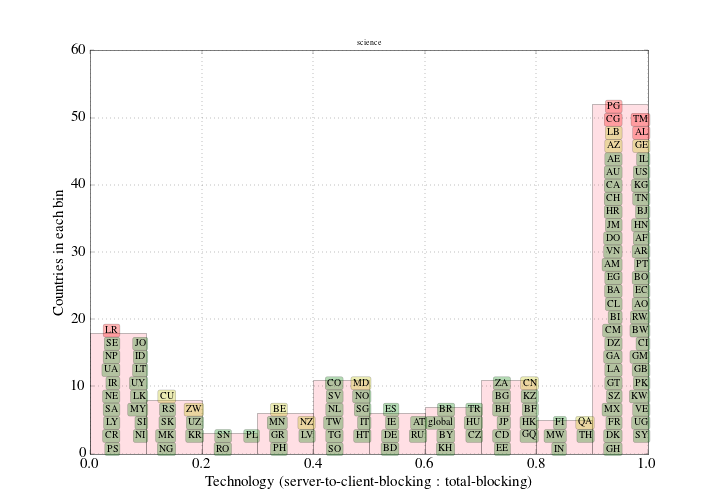

PG 0.95 50.9803921569
science DONE
regional
regional ['198.246.102.49', '216.49.176.33', '15.216.241.18', '207.108.220.154', '206.132.6.134', '203.2.218.214', '121.241.247.61', '208.75.122.14', '172.224.251.210', '23.59.189.89', '2.17.45.41', '23.59.189.106', '170.37.25.140', '165.224.212.39', '74.125.28.101', '163.192.187.17', '159.53.224.21', '223.165.27.13', '166.123.218.220', '124.153.79.225', '153.2.224.50', '129.176.217.220', '207.108.220.136', '173.252.120.6', '155.199.148.111', '128.232.233.16', '141.138.130.12', '184.28.188.154', '134.178.63.172', '213.146.191.132', '208.94.153.100', '94.245.104.73', '23.212.53.190', '165.254.237.138', '192.211.12.20', '54.164.19.177', '130.14.16.110', '192.150.16.117', '68.71.212.186', '184.29.106.57', '170.167.8.1', '140.172.17.21', '212.58.244.20', '74.125.28.104', '54.68.178.116', '203.176.113.78', '171.67.215.200', '170.146.234.214', '173.223.52.200', '134.213.2.238', '54.85.149.231', '159.45.170.143', '174.143.228.153', '199.59.149.230',

<IPython.core.display.Javascript object>


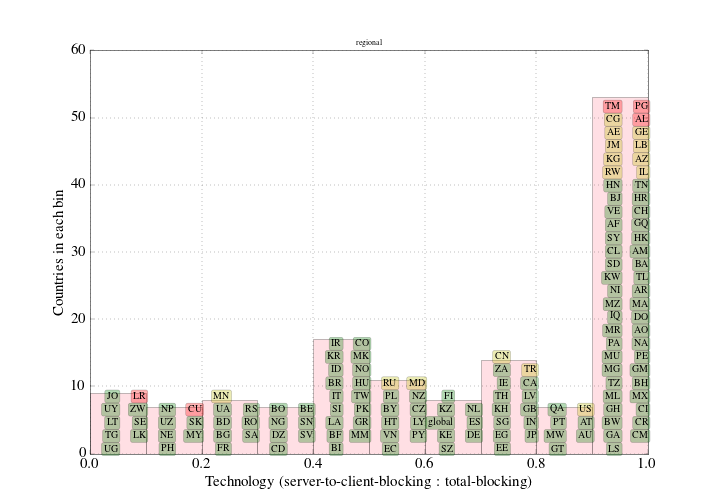

PG 1.0 50.9803921569
regional DONE
health
health ['198.246.102.49', '98.129.100.83', '157.166.226.25', '63.64.130.25', '199.66.166.210', '198.101.191.145', '69.60.134.134', '129.176.217.220', '50.17.211.188', '207.108.220.136', '184.28.188.154', '94.245.104.73', '172.233.29.95', '130.14.16.110', '184.29.106.57', '216.250.171.190', '212.58.244.20', '208.67.123.164', '23.207.61.142', '198.186.175.107', '54.225.69.238', '130.14.29.110']


<IPython.core.display.Javascript object>


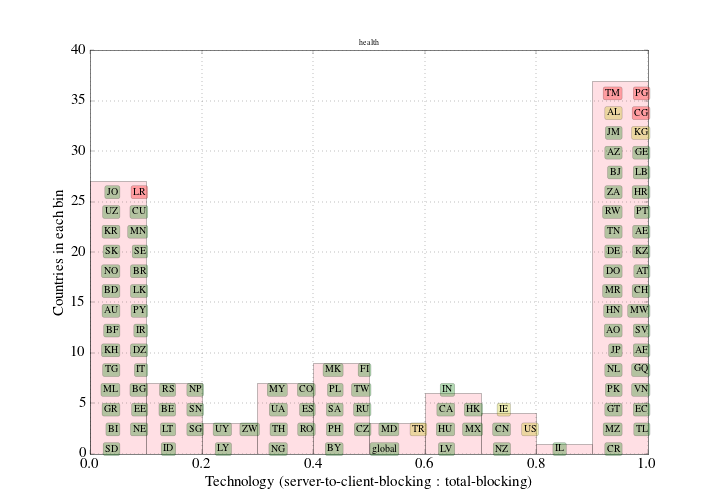

PG 1.0 35.2941176471
health DONE
society
society ['216.49.176.33', '216.115.110.118', '166.78.225.124', '50.18.188.137', '204.9.224.11', '198.50.131.127', '66.155.35.222', '43.253.133.72', '74.125.28.101', '212.100.239.219', '198.104.130.1', '166.123.218.220', '173.252.120.6', '63.143.45.2', '54.164.19.177', '173.231.134.18', '54.236.148.210', '68.169.198.50', '50.16.229.208', '216.34.181.45']


<IPython.core.display.Javascript object>


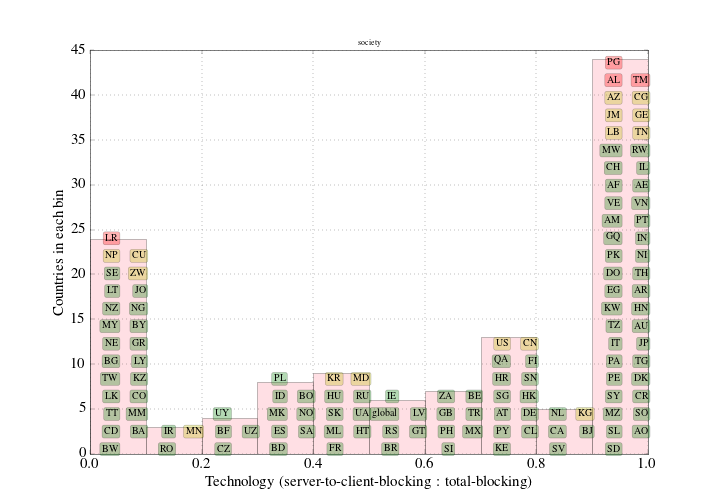

PG 0.95 43.137254902
society DONE
games
games ['54.69.134.181', '192.81.240.190', '134.170.29.82', '166.78.40.244', '23.201.61.210', '199.227.51.26', '216.248.207.17', '141.138.130.12', '64.70.72.166', '72.233.16.130', '64.14.48.177', '129.228.25.181', '202.67.53.202', '107.20.226.78', '54.209.186.217']


<IPython.core.display.Javascript object>


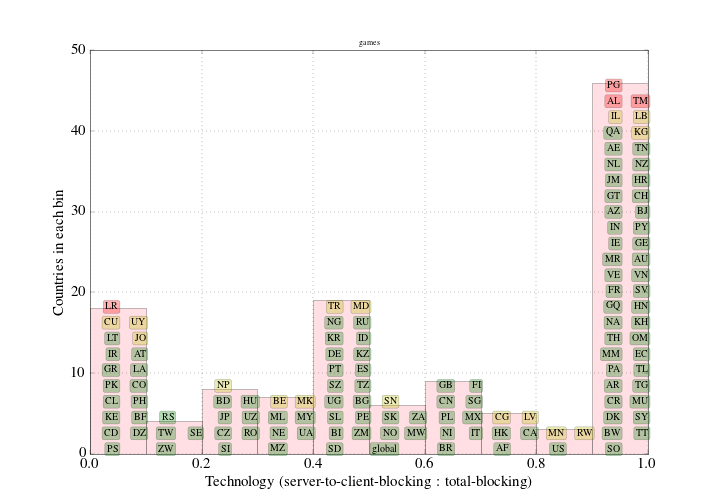

PG 0.95 45.0980392157
games DONE
adult
adult ['37.72.173.157', '141.0.174.40', '74.117.179.22', '216.118.89.130', '68.169.80.241', '204.93.155.69', '66.254.98.132', '173.192.3.190', '209.67.254.80', '199.19.201.199', '74.117.180.88', '69.28.53.205', '158.106.84.60', '109.201.152.100', '67.228.171.11', '207.246.147.179', '208.113.148.140', '109.201.152.98', '69.64.32.253', '199.59.88.246']


<IPython.core.display.Javascript object>


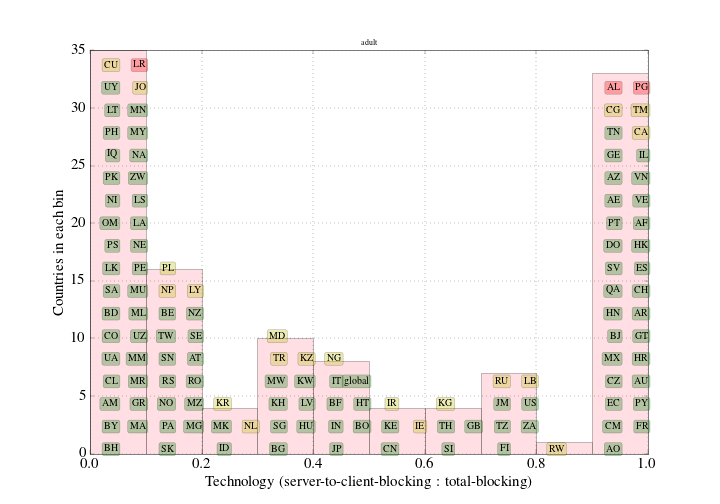

PG 1.0 31.3725490196
adult DONE
shopping
shopping ['206.112.186.66', '23.198.144.45', '207.108.220.154', '198.153.202.150', '54.80.7.219', '23.59.189.106', '170.37.25.140', '23.201.61.210', '206.17.85.131', '74.125.28.101', '98.139.199.204', '128.232.233.16', '23.6.108.215', '23.23.191.68', '165.254.58.27', '165.254.237.138', '170.167.8.1', '206.207.84.93', '68.169.198.50', '208.53.33.118', '134.213.2.238', '23.59.189.112', '172.233.7.37']


<IPython.core.display.Javascript object>


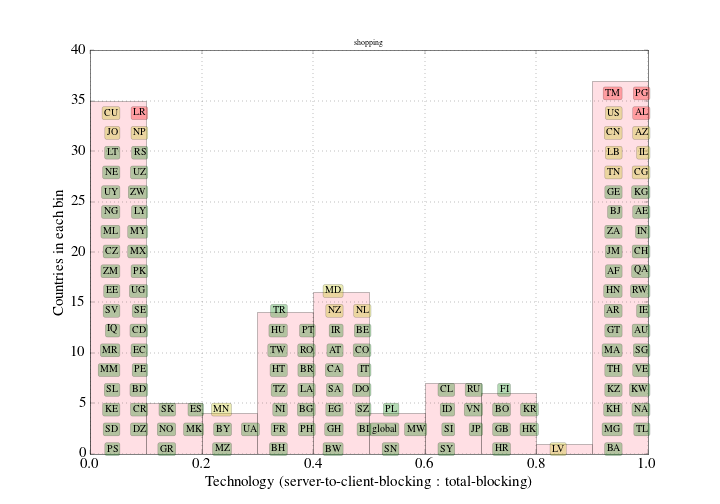

PG 1.0 35.2941176471
shopping DONE
recreation
recreation ['66.151.130.32', '199.204.31.83', '85.232.57.16', '97.107.137.164', '208.253.22.120', '172.224.251.210', '2.17.45.41', '172.224.252.119', '199.102.234.33', '162.13.25.27', '64.6.28.5', '68.169.206.169', '198.211.105.99', '208.94.153.100', '167.187.200.23', '216.220.38.20', '23.63.217.166', '50.18.62.138', '195.62.67.210', '83.140.21.99']


<IPython.core.display.Javascript object>


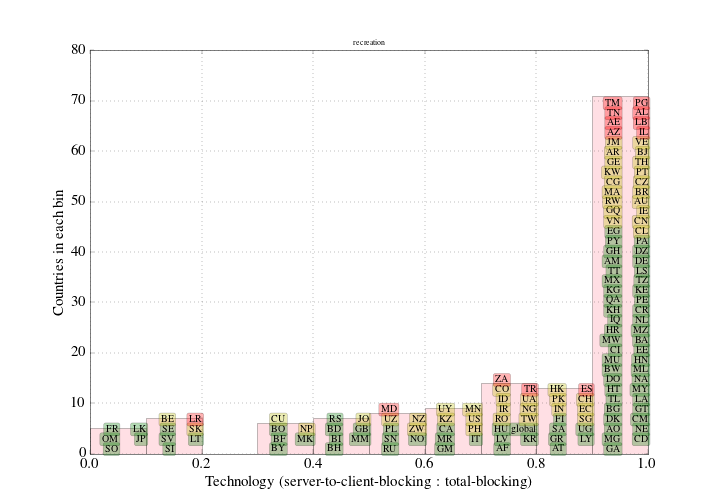

PG 1.0 68.6274509804
recreation DONE
world
world ['15.216.241.18', '208.93.0.150', '85.232.57.16', '185.3.92.89', '74.125.28.102', '74.125.28.100', '54.194.42.5', '74.125.28.94', '196.38.114.178', '173.192.128.45', '173.193.209.232', '74.125.28.101', '74.125.28.99', '197.80.203.123', '98.137.201.252', '153.2.224.50', '173.252.120.6', '74.125.28.83', '152.106.6.100', '216.250.115.137', '212.71.236.107', '74.125.28.113', '192.81.78.114', '192.150.16.117', '8.25.218.36', '192.230.66.165', '212.58.244.20', '128.59.105.24', '50.19.210.76', '62.146.26.38', '195.93.246.56', '213.136.89.190', '74.125.28.104', '8.27.227.126', '208.43.245.148', '196.22.143.67', '134.213.2.238', '65.55.157.144', '213.133.104.105', '198.58.121.66', '199.59.149.230']


<IPython.core.display.Javascript object>


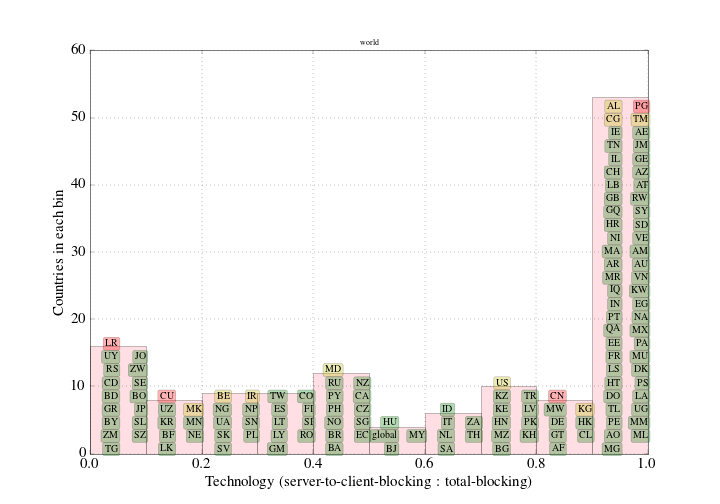

PG 1.0 50.9803921569
world DONE
computers
computers ['15.216.241.18', '208.93.0.150', '208.75.122.14', '74.125.28.100', '140.98.193.141', '134.170.65.86', '172.233.60.20', '74.125.28.101', '198.252.206.140', '98.137.201.252', '66.155.40.250', '199.181.131.249', '108.160.165.20', '74.125.28.83', '107.21.200.171', '74.125.28.113', '192.150.16.117', '74.125.28.104', '54.68.178.116', '107.21.93.21', '207.241.224.2', '128.30.52.45', '74.125.28.136', '65.55.157.144', '208.64.122.67', '216.34.181.45', '199.59.149.230', '66.235.120.127']


<IPython.core.display.Javascript object>


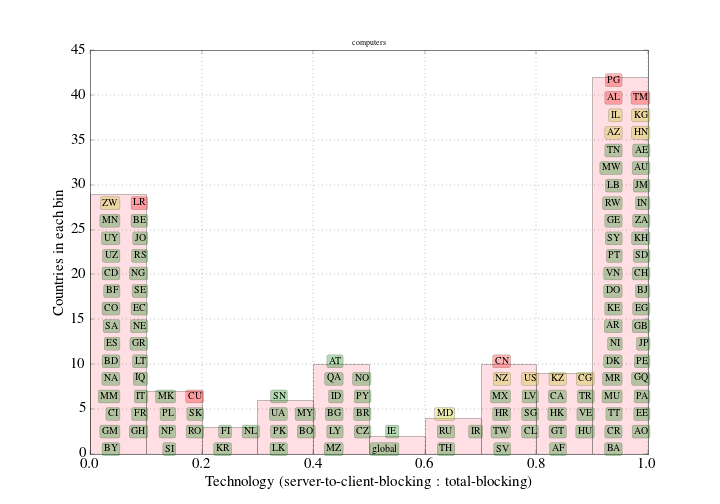

PG 0.95 41.1764705882
computers DONE
reference
reference ['216.115.110.118', '198.35.26.96', '64.124.61.10', '208.93.105.173', '172.233.17.240', '165.224.212.39', '54.88.59.132', '212.100.239.219', '198.252.206.140', '75.101.199.39', '128.97.27.37', '128.232.233.16', '141.211.243.44', '128.83.40.145', '146.186.15.17', '130.14.16.110', '68.71.212.186', '169.229.216.200', '128.59.105.24', '62.146.26.38', '38.69.47.251', '54.236.202.112', '128.253.173.244', '171.67.215.200', '207.241.224.2', '128.30.52.45', '161.58.179.241', '213.133.127.174', '176.65.66.66', '128.95.155.198']


<IPython.core.display.Javascript object>


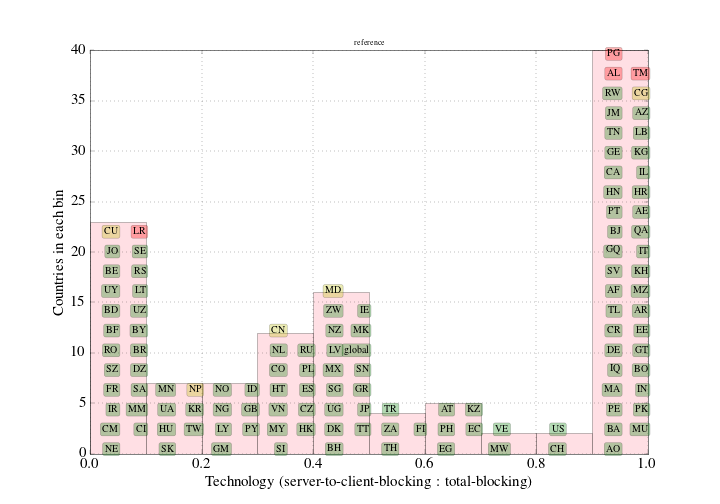

PG 0.95 39.2156862745
reference DONE
arts
arts ['208.93.0.150', '199.15.160.100', '203.2.218.214', '157.166.226.25', '23.59.189.89', '157.166.239.102', '206.220.43.92', '162.13.25.27', '195.244.30.136', '194.132.198.165', '208.85.92.79', '216.115.110.119', '173.252.120.6', '208.85.40.50', '184.28.188.154', '157.166.248.108', '199.85.71.128', '50.204.7.40', '54.164.19.177', '129.228.25.181', '68.71.212.186', '184.29.106.57', '212.58.244.20', '204.236.235.200', '23.23.171.117', '67.135.105.16', '208.78.125.160', '107.23.40.26', '207.223.6.20', '54.209.186.217', '199.59.149.230']


<IPython.core.display.Javascript object>


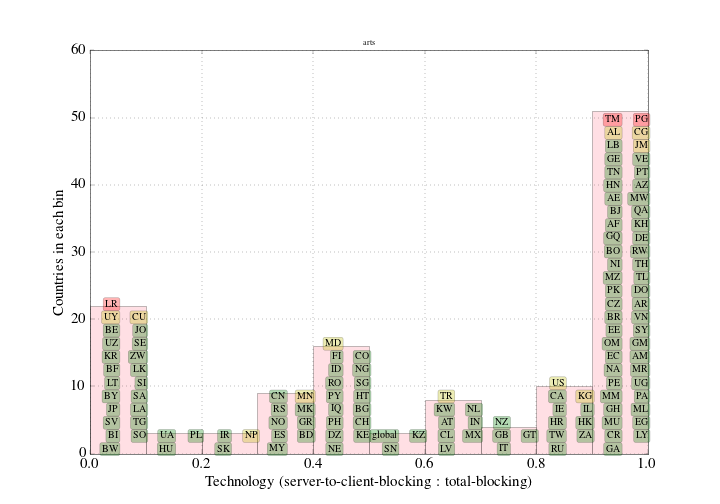

PG 1.0 49.0196078431
arts DONE
business
business ['207.171.3.201', '206.132.6.134', '208.75.122.14', '23.59.189.106', '206.29.177.10', '134.170.65.86', '163.192.187.17', '159.53.224.21', '166.123.218.220', '153.13.148.23', '153.2.224.50', '162.212.41.11', '23.198.162.41', '155.199.148.111', '157.166.248.108', '50.97.195.27', '172.233.29.95', '74.205.63.94', '23.212.53.190', '165.254.58.27', '192.211.12.20', '68.71.212.186', '170.167.8.1', '202.154.164.95', '212.58.244.20', '172.233.25.244', '38.69.47.251', '144.160.36.42', '54.68.178.116', '203.176.113.78', '192.193.219.58', '170.146.234.214', '208.78.125.160', '173.223.52.200', '134.213.2.238', '159.45.170.143']


<IPython.core.display.Javascript object>


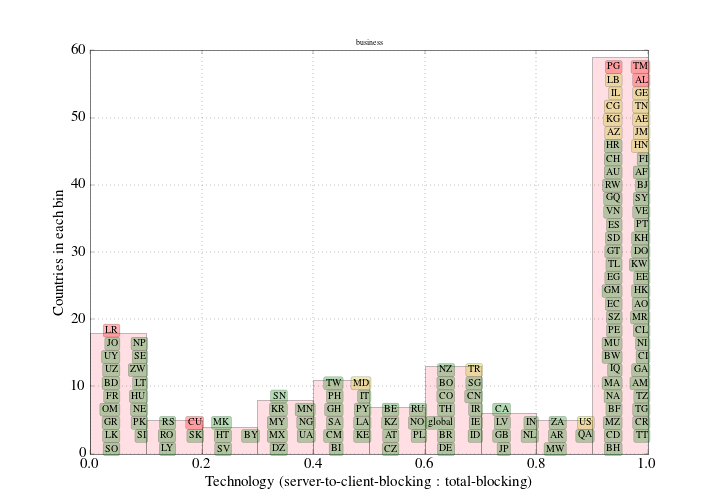

PG 0.95 56.862745098
business DONE
news
news ['206.132.6.134', '97.107.137.164', '121.241.247.61', '157.166.226.25', '23.59.189.89', '208.77.248.169', '74.217.81.233', '163.192.187.17', '124.153.79.225', '162.212.41.11', '184.28.188.154', '213.146.191.132', '157.166.248.108', '50.204.7.40', '23.212.53.190', '207.108.220.146', '184.29.106.57', '8.25.218.36', '212.58.244.20', '54.85.149.231', '207.223.6.20', '174.143.228.153', '184.73.190.53']


<IPython.core.display.Javascript object>


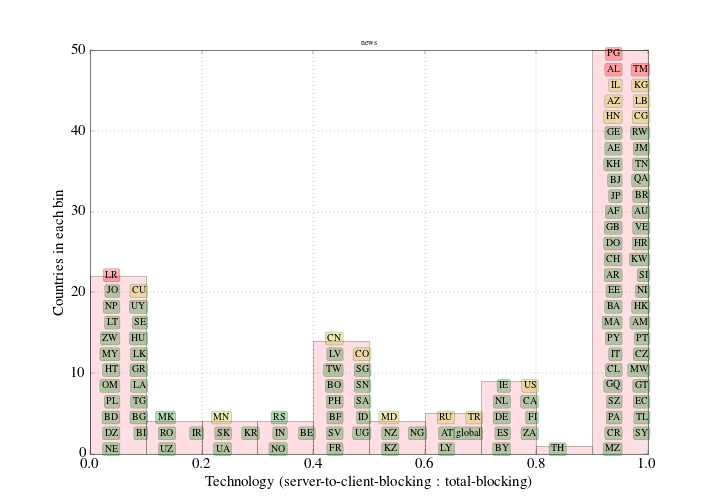

PG 0.95 49.0196078431
news DONE
sports
sports ['137.135.42.143', '199.181.133.45', '163.192.187.17', '207.108.220.136', '64.210.192.54', '213.146.191.132', '199.85.71.128', '54.246.159.107', '68.71.212.186', '184.29.106.57', '216.187.121.100', '209.73.183.31', '212.58.244.20', '157.166.248.245', '184.28.188.74', '107.21.120.232', '54.225.67.222', '96.17.202.179', '184.25.56.179']


<IPython.core.display.Javascript object>


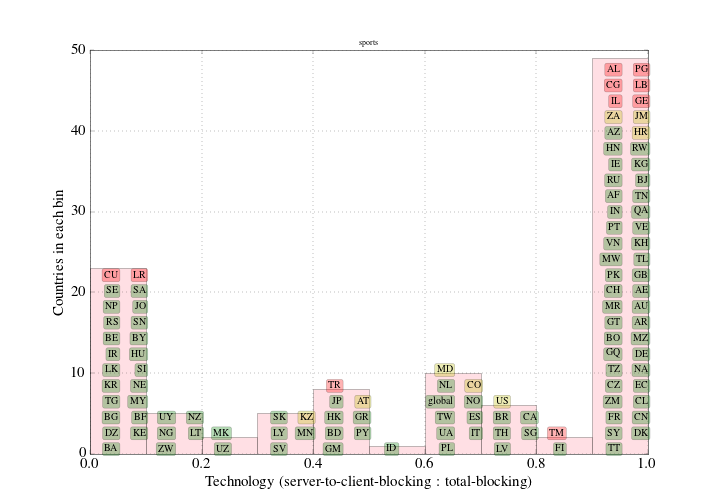

PG 1.0 47.0588235294
sports DONE
home
home ['208.253.22.120', '64.94.140.201', '74.205.22.3', '209.126.235.135', '166.123.218.220', '74.63.145.186', '153.13.148.23', '98.139.199.204', '207.198.114.123', '172.225.10.194', '157.166.248.108', '69.60.11.100', '198.51.132.180', '198.211.105.99', '50.204.7.40', '204.78.50.82', '198.186.175.108', '212.58.244.20', '23.3.87.153', '72.233.105.58', '207.223.6.20']


<IPython.core.display.Javascript object>


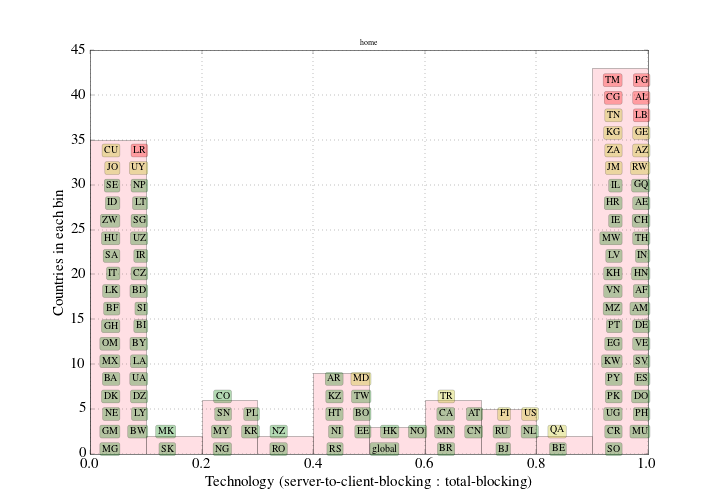

PG 1.0 41.1764705882
home DONE
teens
teens ['74.125.28.102', '134.170.29.82', '157.166.226.25', '157.166.239.102', '172.233.17.240', '166.70.35.136', '54.88.59.132', '199.167.42.108', '199.227.51.26', '74.125.28.101', '208.85.92.79', '134.178.63.172', '212.72.60.220', '216.220.38.20', '129.228.25.181', '212.58.244.20', '202.67.53.202', '184.28.188.74', '54.174.118.57', '54.68.178.116', '208.67.123.164', '107.20.226.78', '195.62.67.210', '23.23.224.106', '54.209.186.217', '185.26.230.129']


<IPython.core.display.Javascript object>


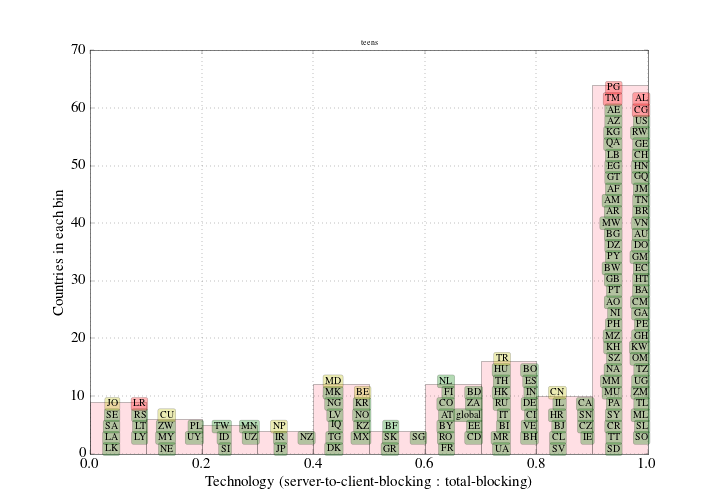

PG 0.95 62.7450980392
teens DONE
circum
circum ['54.230.219.62', '107.170.93.98', '82.196.1.165', '205.251.253.116', '192.249.116.218', '199.119.112.23', '204.13.164.188', '80.68.94.117', '1.209.122.23', '38.101.236.62', '173.236.226.119', '209.234.253.125', '82.195.75.101', '194.150.168.119', '194.109.206.212', '193.23.244.244', '131.188.40.189', '50.62.247.1', '199.254.238.52']


<IPython.core.display.Javascript object>


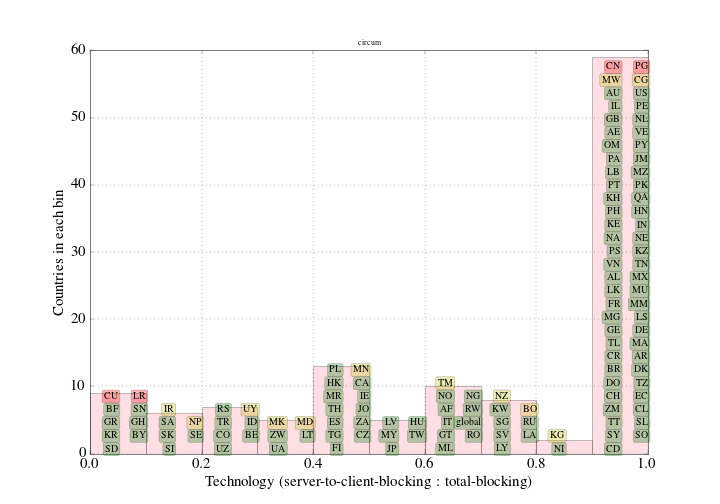

PG 1.0 56.862745098
circum DONE
vpn
vpn ['216.131.114.237', '74.115.2.240', '69.167.173.133', '104.130.112.72', '69.16.128.162', '54.164.120.232', '192.227.157.40', '23.105.170.38', '68.68.107.161', '208.64.122.67', '109.169.47.177']


<IPython.core.display.Javascript object>


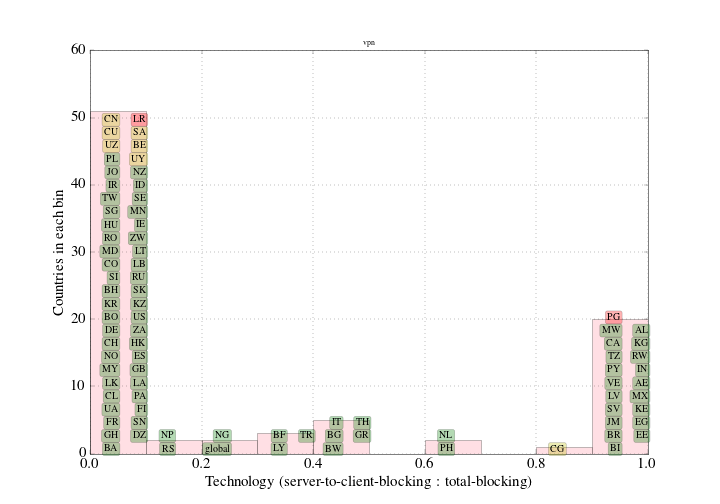

PG 0.95 19.6078431373
vpn DONE


In [321]:
if not os.path.exists(PLOTS + "subcat/"):
    os.makedirs(PLOTS + "subcat/")

for subcat in df_sIP_subcat_disjoint['subcat'].unique():
    plot_country_technique_for_subcat(subcat)